# 정책 기반 접근법 - REINFORCE 알고리즘

## [정책 기반 접근 (Policy-based Method)]

* **Q 함수**를 명시적으로 사용 **않고**, **정책** 자체를 직접 파라미터화하여 최적화
  *   정책 $\pi_\theta(a|s)$: 상태 s에서 행동 a를 선택할 확률
* **가치 기반 방법**은 **상태-행동 가치함수** $Q^*(s,a)$ 를 직접 근사하여 학습하고, 매 상태마다  Q 값이 최대인 행동을 선택
* **정책 기반 방법**은 가치 함수를 통하지 않고 정책 자체를 직접 최적화하는 접근
* **장점**
  * **연속적** 및 **큰 행동 공간** 처리 용이
    * Q-테이블이나 Q-함수를 모든 행동에 대해 근사하는 것이 어려운 상황에서 정책을 직접 근사하면 편리
    * **확률적 정책**으로 **탐험** 내장
      * 정책이 확률적으로 행동을 샘플링하기 때문에, 별도의 탐색 전략 없이도 자연스럽게 탐색이 이루어짐
    * 정책 개선의 **직관성**: "정책의 기대 return을 최대화"하는 것이 목표, 직접 최적화 가능
* **단점**
  * 가치 기반 방법에 비해 **학습이 불안정**할 수 있음


## [REINFORCE 알고리즘]

* **몬테카를로 정책 경사법**: 에피소드 전체를 경험한 후 정책 업데이트
* **정책 경사 정리** (Policy Gradient Theorem)
  * 정책의 성능에 대한 **그래디언트**를 추정, 경사 상승(gradient ascent)으로 정책 파라미터 업데이트
    * 정책의 성능을 개선하는 방향으로 정책 파라미터를 조정
  * 수식: $\nabla_\theta J(\theta) = E_\pi \big[\, \nabla_\theta \log \pi_\theta(A_t \mid S_t)\, G_t \,\big]$
    * $G_t$: $t$ 시점부터의 **반환** (return)
    * **직관적 의미**: 보상을 많이 받은 행동들의 확률을 높이는 방향으로 정책 업데이트
      * 어떤 행동을 했을 때, 그 행동이 가져다 준 결과가 좋았다면, 그 행동을 할 확률을 높이는 방식으로 학습
* **업데이트 식**
  * $\theta \leftarrow \theta + \alpha\, G_t \, \nabla_\theta \log \pi_\theta(A_t \mid S_t)$
    * $\alpha$: 학습률
    * **보상이 크면** 그 때 실행했던 행동의 **확률 증가**, 보상이 나쁘면 확률 감소
      * 예: 게임에서 특정 행동을 했을 때 점수를 많이 얻었다면, 다음에 비슷한 상황에서 그 행동을 선택할 확률을 높임
* **REINFORCE with Advantage**
  * **어드밴티지 함수** $A_t = G_t - V^\pi(S_t)$ : $G_t$ 대신 $A_t$ 사용
      * $V^\pi(S_t)$: 상태 가치 함수
      * 어드밴티지 함수는 특정 상태에서 행동을 했을 때 얻을 수 있는 **추가적인** 이득을 나타냄
      * 보상의 평균 수준을 빼주어 편차만 갖고 학습하는 기법 (Dueling DQN에서 등장했던 개념)

## [REINFORCE 구현]

*  **정책 네트워크** 설계
  * 상태를 입력받아 행동에 대한 확률 분포를 출력하는 신경망
  * $\pi(a|s)$: 상태 $s$에서 행동 $a$를 선택할 확률
  * $\psi_a$: 행동 $a$에 해당하는 Layer 2의 출력 값

\begin{array}{c}
\boxed{\text{Input: State }(s)} \\
\downarrow \\
\boxed{\text{Layer 1: Fully Connected (Linear), } \phi = W_1 s + b_1} \\
\downarrow \\
\boxed{\text{Activation Function: ReLU (Rectified Linear Unit), } a = \max(0, \phi)} \\
\downarrow \\
\boxed{\text{Layer 2: Fully Connected (Linear), } \psi = W_2 a + b_2} \\
\downarrow \\
\boxed{\text{Output Activation: Softmax}, \pi(a|s) = \frac{e^{\psi_a}}{\sum_{a'} e^{\psi_{a'}}}} \\
\downarrow \\
\boxed{\text{Output: Action Probabilities } \pi(a|s)\;}
\end{array}

* **에피소드**를 **수집**
  * 환경과 상호작용하면서 상태, 행동, 보상 등의 데이터를 수집
* **수집된 에피소드**를 사용하여 **정책 업데이트**
  * 정책 경사 정리와 업데이트 식을 사용하여 정책 네트워크의 파라미터를 업데이트
  REINFORCE 알고리즘의 정책 업데이트 과정을 수식으로 나타내면 다음과 같습니다. 핵심은 정책 경사(policy gradient)를 이용하여 정책 파라미터를 업데이트하는 것입니다.


### 1. 기본 표기

* $\theta$: 정책 신경망의 파라미터 (가중치, 편향)
* $\pi_\theta(a|s)$: 파라미터 $\theta$를 가진 정책 (상태 $s$에서 행동 $a$를 할 확률)
* $R_t = \sum_{k=t}^{T}\gamma^{k-t} r_k$: 시간 $t$부터 에피소드 끝까지의 할인된 총 보상  
    * $r_k$: 시간 $k$에서의 보상
    * $\gamma$: 할인율 (discount factor, $0 \le \gamma \le 1$)
    * $T$: 에피소드의 종료 시간
* $\nabla_\theta$: $\theta$에 대한 gradient

### 2. 정책 경사 (Policy Gradient) 계산

$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) R_t \right]$

* $J(\theta)$: 정책의 성능 지표 (기대값)  
  * REINFORCE에서는 에피소드 동안 얻은 총 보상의 기대값
* $\mathbb{E}_{\tau \sim \pi_\theta}[\cdot]$: 정책 $\pi_\theta$를 따라 생성된 trajectory $\tau = (s_0, a_0, r_1, s_1, a_1, ... , s_T, a_T)$에 대한 기대값
*  $\nabla_\theta \log \pi_\theta(a_t|s_t)$:  로그 정책(log policy)의 그래디언트  
  * 정책 $\pi_\theta$가 상태 $s_t$에서 행동 $a_t$를 선택할 확률을 높이는 방향을 나타냄
* $R_t$: 시간 t부터의 return

### 3. 정책 업데이트 (Policy Update) 계산

* 정책 경사를 계산한 후, 경사 상승법(gradient ascent)을 사용하여 정책 파라미터를 업데이트

* $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$

  * $\alpha$: 학습률 (learning rate)

### 4. 몬테카를로 근사 (Monte Carlo Approximation)

* 실제로는 기대값을 정확하게 계산할 수 없으므로, 몬테카를로 샘플링을 사용하여 근사  
* 하나의 에피소드 $\tau$를 샘플링하여 정책 경사를 다음과 같이 추정
* $\nabla_\theta J(\theta) \approx  \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) R_t$

### 5. 최종 업데이트 규칙 (Final Update Rule)

* $\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) R_t$
  * 로그 정책의 그래디언트 $\nabla_\theta \log \pi_\theta(a_t|s_t)$
    * 정책이 현재 행동을 더 많이/적게 선택하도록 하는 방향
  * $t$ 이후 얻은 총 보상(return) $R_t$
    * 좋은 행동이었다면 양수, 나쁜 행동이었다면 음수
  * 학습율 $\alpha$
    * 업데이트 크기 조절

## [한계]

* **높은 분산**: 에피소드 단위로 Return 계산, 긴 에피소드/복잡한 문제에서 분산이 커져 업데이트 효율 감소
  * REINFORCE는 에피소드가 끝난 후에만 정책을 업데이트할 수 있기 때문에, 에피소드 중간에 얻은 정보를 활용하기 어려움
* **느린 반응**: 에피소드가 끝나야 업데이트, 실시간 반응 어려움
  * 환경의 변화에 즉각적으로 대응하기 어려움
* **해결**: Actor-Critic 방법 (**Next Week**)
  * Actor-Critic 방법은 정책을 결정하는 Actor와 가치를 평가하는 Critic을 동시에 학습시켜, REINFORCE의 단점을 보완

## [실습: REINFORCE]

### 1. 필수 라이브러리 설치 및 가져오기


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import imageio

### 2. 하이퍼파라미터 설정

*   `learning_rate`: 학습률
*   `gamma`: 할인율
*   `n_episodes`: 최대 에피소드 수
*   `print_interval`: 진행 상황 출력 주기
*  `early_stopping_patience`: 조기 종료 patience (얼마나 기다릴지)
* `target_score`: 목표 점수 (이 점수 넘으면 학습 성공)

In [2]:
learning_rate = 0.0003
gamma = 0.99
n_episodes = 3000  # 최대 에피소드 수
print_interval = 50 # 중간 결과 출력 주기
early_stopping_patience = 10 # 연속으로 target_score를 넘기는 횟수
target_score = 400  # CartPole-v1 성공 기준 (보통 200점 이상 성공)

### 3. 신경망 모델 (Policy Network) 정의

*   간단한 2층 신경망 (입력층-은닉층-출력층)
*   `forward()`:  `softmax`로 확률 분포 반환

In [3]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=0)  # 단일 state에 대한 확률

### 4. REINFORCE 알고리즘 구현 (train 함수)

*   `optimizer`: Adam 옵티마이저 사용
*   에피소드별:
    *   `rewards`, `log_probs`: 보상, 로그 확률 저장 리스트
    *   `done`이 `True`일 때까지:
        *   `policy(state)`로 확률 분포 얻고, `Categorical`로 행동 샘플링, 로그 확률 계산
        *   `env.step()`으로 행동, 보상, 종료 여부 등 받음
        *   `rewards`, `log_probs`에 저장
        *   `state` 업데이트
    *   에피소드 끝나면:
        *   `R`: return (할인된 총 보상) 계산
        *   `policy_loss`:  `-log_prob * R`의 합 (기본 REINFORCE 손실)
        *   `optimizer`로 policy 업데이트 (경사 상승)
    *   `print_interval`마다 평균 점수 출력, 조기 종료 조건 확인

In [5]:
def train(env, policy, optimizer, n_episodes, gamma, print_interval, early_stopping_patience, target_score):
    scores = []

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # gym 버전 호환
        state = torch.from_numpy(state).float()

        rewards = []
        log_probs = []
        done = False

        while not done:
            probs = policy(state)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(log_prob)
            state = torch.from_numpy(next_state).float()
            done = terminated or truncated

        # Return 계산
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)

        # Policy Loss 계산 (기본적인 형태)
        returns = torch.tensor(returns) # list를 tensor로
        log_probs = torch.stack(log_probs) # list of tensor를 tensor로
        policy_loss = torch.sum(-log_probs * returns)

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        scores.append(total_reward)

        if (i_episode+1) % print_interval == 0:
            avg_score = np.mean(scores[-print_interval:])
            print(f"Episode {(i_episode+1)}\tAverage Score: {avg_score:.2f}")

        if np.min(scores[-early_stopping_patience:])>=target_score:
            print(f"Early stopping after {i_episode+1} episodes.  Target score reached.")
            break

    return scores

### 5. 학습 실행 및 결과 확인

Episode 50	Average Score: 29.59
Episode 100	Average Score: 29.46
Episode 150	Average Score: 22.94
Episode 200	Average Score: 28.10
Episode 250	Average Score: 33.60
Episode 300	Average Score: 31.22
Episode 350	Average Score: 35.42
Episode 400	Average Score: 38.36
Episode 450	Average Score: 33.10
Episode 500	Average Score: 42.88
Episode 550	Average Score: 46.48
Episode 600	Average Score: 55.06
Episode 650	Average Score: 52.90
Episode 700	Average Score: 56.98
Episode 750	Average Score: 60.50
Episode 800	Average Score: 49.84
Episode 850	Average Score: 61.66
Episode 900	Average Score: 68.46
Episode 950	Average Score: 70.76
Episode 1000	Average Score: 87.88
Episode 1050	Average Score: 95.34
Episode 1100	Average Score: 104.16
Episode 1150	Average Score: 112.28
Episode 1200	Average Score: 161.80
Episode 1250	Average Score: 148.26
Episode 1300	Average Score: 151.28
Episode 1350	Average Score: 194.38
Episode 1400	Average Score: 209.04
Episode 1450	Average Score: 223.46
Episode 1500	Average Score

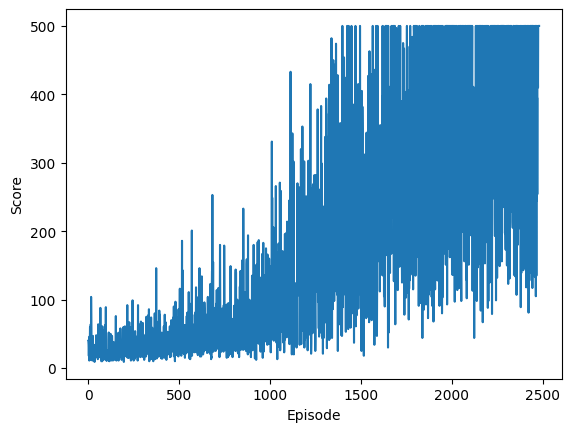

In [6]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy = Policy(state_size, action_size)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

scores = train(env, policy, optimizer, n_episodes, gamma, print_interval, early_stopping_patience, target_score)

plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

In [7]:
state, _ = env.reset()
if isinstance(state, tuple):
    state = state[0]
state = torch.from_numpy(state).float()

frames = []
total_reward = 0
done = False

while not done:
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()

    next_state, reward, terminated, truncated, _ = env.step(action.item())
    total_reward += reward
    state = torch.from_numpy(next_state).float()
    done = terminated or truncated
    frames.append(env.render())

imageio.mimsave("cartpole_simulation_reinforce.gif", frames, duration=33)  # duration 조절
print(f"Total reward: {total_reward}")
env.close()


Total reward: 500.0
